In [232]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

from cnp.data import GPGenerator

from cnp.cnp import StandardConvGNP
from cnp.cov import InnerProdCov, MeanFieldCov, AddNoNoise, AddHomoNoise

import stheno

import matplotlib
matplotlib.rcParams['text.usetex'] = True

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
plot_grid_res = 100
num_samples = 50
xmin = -4.5
xmax = 4.5
ymin = -5
ymax = 5
num_basis_dim = 512

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
kernel = stheno.EQ().stretch(1.)
std_noise = 1e-1

gen_params = {
    'batch_size'                : 1,
    'x_context_ranges'          : [[-3., 3.]],
    'max_num_context'           : 3,
    'min_num_target'            : 3,
    'max_num_target'            : 10,
    'device'                    : 'cpu'
}

gen = GPGenerator(iterations_per_epoch=1,
                  kernel=kernel,
                  std_noise=std_noise,
                  **gen_params)

seed = 5

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mean field ConvGNP

In [179]:
def pdf(x_grid, mean, cov):
    
    diff = x_grid - mean[None, None, :]
    
    i = diff.shape[0]
    j = diff.shape[1]
    
    diff_ = np.reshape(diff, (-1, 2)).T
    quad = np.linalg.solve(cov, diff_)
    quad = np.reshape(quad.T, (i, j, 2))
    quad = - np.einsum('ijk, ijk -> ij', diff, quad)
    
    return quad

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
xpt = np.array([0., 0.5])
ypt = np.array([-1.0, -1.0])

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [332]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])


np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


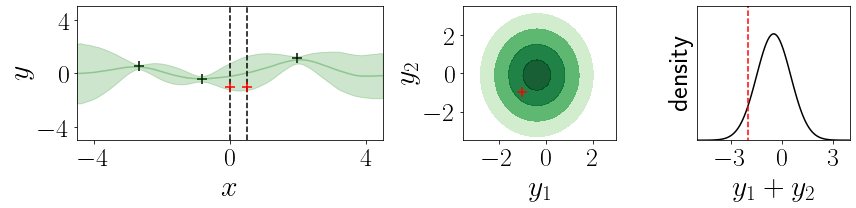

In [333]:
x_pred = np.array([[[0.], [0.5]]])
x_pred = torch.tensor(x_pred).float()
x_pdf = np.linspace(-5., 4., 100)

model_output = model(x_context, y_context, x_pred)
mean_pred, cov_pred, _ = [v.detach().numpy() for v in model_output]
cov_pred[0, 0, 1] = 0.
cov_pred[0, 1, 0] = 0.

x_pred = x_pred.numpy()

std_dev = np.diag(cov[idx]) ** 0.5

f, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 1]}, figsize=(12, 3.))

x1_grid = np.linspace(-3.5, 3., 30)
x2_grid = np.linspace(-3.5, 3.5, 30)
x_grid = np.stack(np.meshgrid(x1_grid, x2_grid), axis=-1)
p = pdf(x_grid, mean_pred[0, :, 0], cov_pred[0, :, :])
    
#==============================================================================
# First plot
#==============================================================================

ax0.scatter(x_context[idx, :, 0],
            y_context[idx, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context')

ax0.scatter(xpt,
            ypt,
            marker='+',
            color='red',
            s=100,
            zorder=5)

ax0.fill_between(x_plot[idx, :, 0],
                 mean[idx, :, 0] - 2 * std_dev,
                 mean[idx, :, 0] + 2 * std_dev,
                 color='green',
                 alpha=0.2)

ax0.plot(x_plot[idx, :, 0],
         mean[idx, :, 0],
         color='green',
         alpha=0.3)

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax0.set_xticks(np.linspace(-4, 4, 3))
ax0.set_yticks(np.linspace(-4, 4, 3))
ax0.set_xlabel('$x$', fontsize=30)
ax0.set_ylabel('$y$', fontsize=30)
for t in ax0.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax0.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
ax0.plot([x_pred[0, 0, 0], x_pred[0, 0, 0]], [-5., 5], '--', color='black')
ax0.plot([x_pred[0, 1, 0], x_pred[0, 1, 0]], [-5., 5], '--', color='black')
    
#==============================================================================
# Second plot
#==============================================================================

ax1.contourf(x1_grid, x2_grid, p, levels=-np.arange(4, -0.1, -1)**2, cmap='Greens', alpha=0.9)
ax1.scatter(ypt[:1],
            ypt[1:],
            marker='+',
            color='red',
            s=100,
            zorder=5)

ax1.set_xticks(np.linspace(-2, 2, 3))
ax1.set_yticks(np.linspace(-2, 2, 3))
ax1.set_xlabel('$y_1$', fontsize=30)
ax1.set_ylabel('$y_2$', fontsize=30)

for t in ax1.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax1.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
#==============================================================================
# Third plot
#==============================================================================

sum_mean = np.sum(mean_pred[0, :, 0])
sum_var = cov_pred[0, 0, 0] + cov_pred[0, 1, 1] + 2 * cov_pred[0, 0, 1]
sum_std = sum_var ** 0.5

normal = norm(loc=sum_mean, scale=sum_std)
norm_pdf = normal.pdf(x_pdf)

ax2.plot(x_pdf, norm_pdf, color='k')

ax2.set_xticks(np.linspace(-3, 3, 3))
ax2.set_yticks([])
ax2.set_xlim([-5, 4])
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('$y_1 + y_2$', fontsize=30)
ax2.set_ylabel('density', fontsize=28)

ax2.plot([ypt.sum(), ypt.sum()], [-0.1, 2], '--', color='red')

for t in ax2.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
plt.tight_layout()
plt.savefig('./plots/meanfield-covdemo.pdf')
plt.show()

In [334]:
inner_prod_cov = InnerProdCov(num_basis_dim=num_basis_dim)
add_homo_noise = AddHomoNoise()

innerprod_conv_gnp_path = './models/innerprod-convGNP'

model = StandardConvGNP(input_dim=1,
                        covariance=inner_prod_cov,
                        add_noise=add_homo_noise,
                        num_noise_channels=0)

model.load_state_dict(torch.load(innerprod_conv_gnp_path, map_location=torch.device('cpu'))['state_dict'])


np.random.seed(seed)
torch.manual_seed(seed)

data = list(gen)[0]

x_context = data['x_context']
x_target = data['x_target']
y_context = data['y_context']
y_target = data['y_target']

x_plot = torch.linspace(xmin, xmax, plot_grid_res)[None, :, None]
x_plot_rep = x_plot[:, :, 0].repeat(num_samples, 1)
x_plot = x_plot.repeat(x_context.shape[0], 1, 1)

model_output = model(x_context, y_context, x_plot)
mean, cov, cov_plus_noise = [v.detach().numpy() for v in model_output]

/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/stratis/repos/kernelcnp/venv-gnp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


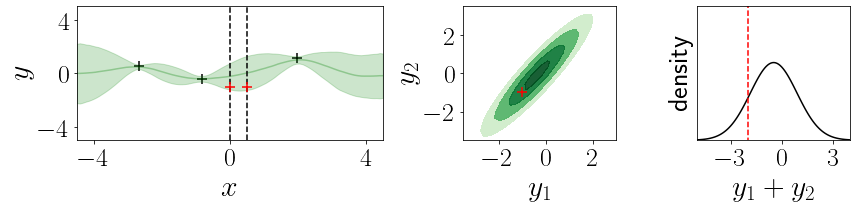

In [335]:
x_pred = np.array([[[0.], [0.5]]])
x_pred = torch.tensor(x_pred).float()
x_pdf = np.linspace(-5., 4., 100)

model_output = model(x_context, y_context, x_pred)
mean_pred, cov_pred, _ = [v.detach().numpy() for v in model_output]

x_pred = x_pred.numpy()

std_dev = np.diag(cov[idx]) ** 0.5

f, (ax0, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 1]}, figsize=(12, 3.))

x1_grid = np.linspace(-3.5, 3., 30)
x2_grid = np.linspace(-3.5, 3.5, 30)
x_grid = np.stack(np.meshgrid(x1_grid, x2_grid), axis=-1)
p = pdf(x_grid, mean_pred[0, :, 0], cov_pred[0, :, :])
    
#==============================================================================
# First plot
#==============================================================================

ax0.scatter(x_context[idx, :, 0],
            y_context[idx, :, 0],
            marker='+',
            color='black',
            s=100,
            label='Context')

ax0.scatter(xpt,
            ypt,
            marker='+',
            color='red',
            s=100,
            zorder=5)

ax0.fill_between(x_plot[idx, :, 0],
                 mean[idx, :, 0] - 2 * std_dev,
                 mean[idx, :, 0] + 2 * std_dev,
                 color='green',
                 alpha=0.2)

ax0.plot(x_plot[idx, :, 0],
         mean[idx, :, 0],
         color='green',
         alpha=0.3)

ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
ax0.set_xticks(np.linspace(-4, 4, 3))
ax0.set_yticks(np.linspace(-4, 4, 3))
ax0.set_xlabel('$x$', fontsize=30)
ax0.set_ylabel('$y$', fontsize=30)
for t in ax0.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax0.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
ax0.plot([x_pred[0, 0, 0], x_pred[0, 0, 0]], [-5., 5], '--', color='black')
ax0.plot([x_pred[0, 1, 0], x_pred[0, 1, 0]], [-5., 5], '--', color='black')
    
#==============================================================================
# Second plot
#==============================================================================

ax1.contourf(x1_grid, x2_grid, p, levels=-np.arange(4, -0.1, -1)**2, cmap='Greens', alpha=0.9)
ax1.scatter(ypt[:1],
            ypt[1:],
            marker='+',
            color='red',
            s=100,
            zorder=5)

ax1.set_xticks(np.linspace(-2, 2, 3))
ax1.set_yticks(np.linspace(-2, 2, 3))
ax1.set_xlabel('$y_1$', fontsize=30)
ax1.set_ylabel('$y_2$', fontsize=30)

for t in ax1.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
for t in ax1.yaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
#==============================================================================
# Third plot
#==============================================================================

sum_mean = np.sum(mean_pred[0, :, 0])
sum_var = cov_pred[0, 0, 0] + cov_pred[0, 1, 1] + 2 * cov_pred[0, 0, 1]
sum_std = sum_var ** 0.5

normal = norm(loc=sum_mean, scale=sum_std)
norm_pdf = normal.pdf(x_pdf)

ax2.plot(x_pdf, norm_pdf, color='k')

ax2.set_xticks(np.linspace(-3, 3, 3))
ax2.set_yticks([])
ax2.set_xlim([-5, 4])
ax2.set_ylim([0, 0.5])
ax2.set_xlabel('$y_1 + y_2$', fontsize=30)
ax2.set_ylabel('density', fontsize=28)

ax2.plot([ypt.sum(), ypt.sum()], [-0.1, 2], '--', color='red')

for t in ax2.xaxis.get_major_ticks():
    t.label.set_fontsize(26)
    
plt.tight_layout()
plt.savefig('./plots/innerprod-covdemo.pdf')
plt.show()